In [ ]:
"""
This script conducts a simple linear regression analysis. It regresses Lights at Night to Electrification
Rates at the village-level for Bihar, India. Villages w/o valid data are dropped via NaN.

The original dataframe is pulled in from a csv containing 1) 2011 Census ID, 2) Village Name, 2) mean Lights 
at Night radiance, and 4) Electrification Percentage.

Additionally, data exploration techniques are applied via hisograms and 2D histograms. Note these plots have
been customized, including an automated calculation and feed of the mean and standard deviation feed into the
plot's title.

The linear regrssion model results are calculated using MSE and r^2 values.

Lastly, the csv for the second regression analysis (multiple variables) is brought into assist with plotting.
Specifically, a multicollinearity plot is plotted to evaluate correlation between independent variables. That
specific code chunk was copied to the multiple regression team's script.
"""

In [211]:
import gdal
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd
import os
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt
import pylab
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score
import numpy

In [212]:
df = pd.read_csv('final_data.csv')

In [214]:
### drop villages with NaN values
df2 = df[['Census 2011 ID', 'Village Name', 'Lights at Night', 'Percentage Electrified']].copy()
df3 = df2.dropna()
df3.head(50)

,Census 2011 ID,Village Name,Lights at Night,Percentage Electrified
1,215989,Kalapani,0.339502,9.438202
2,215991,Tharhi,0.475338,63.126844
5,215992,Pipra,1.013760,55.140187
9,215993,Kotaraha,0.561286,50.000000
13,215995,Lachhmipur,0.400720,73.008130
16,215996,Daruabari,0.319399,67.804878
18,215994,Rampurwa,0.808615,16.253444
22,215997,Santpur,0.294560,98.477157
23,215999,Parsauni,0.532531,13.513514
25,215998,Soharia,0.384130,76.951673


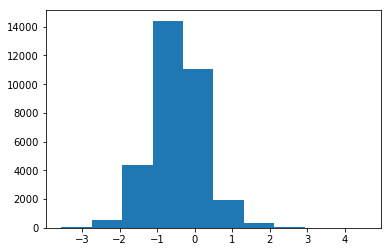

-3.55452340161


In [215]:
### basic histogram check
x = np.log(df3['Lights at Night'])
plt.hist(x)
plt.show()
x_max = np.min(x)
print(x_max)

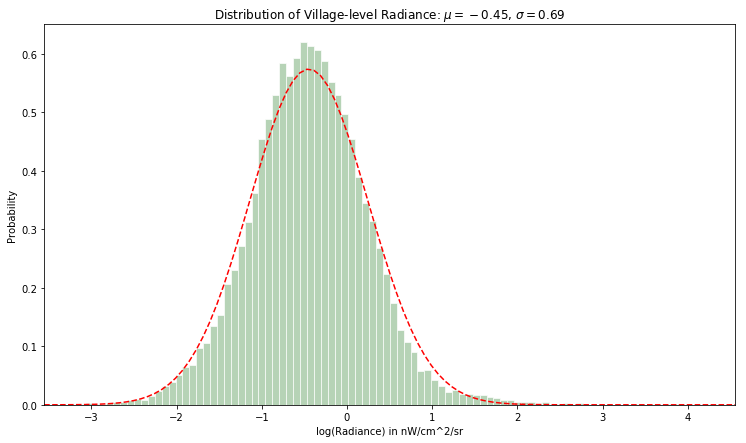

In [335]:
### log-transformed distribution of radiance values

x = np.log(df3['Lights at Night'])
num_bins = 100
plt.figure(figsize=(12,7))
n, bins, patches = plt.hist(x, num_bins, normed=1, facecolor='darkseagreen', alpha=0.65, edgecolor=(1,1,1))

### mean and standard deviation calc's
mu = np.mean(x)
sigma = np.std(x)

# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'r--')
plt.xlabel('log(Radiance) in nW/cm^2/sr')
plt.ylabel('Probability')
plt.title('Distribution of Village-level Radiance: $\mu={:0.2}$, $\sigma={:0.2}$'.format(mu, sigma))

# tweak spacing to prevent clipping of ylabel and set axis ranges to include all values
plt.subplots_adjust(left=0.1)
#pylab.ylim([0,y.max()])
pylab.xlim([x.min(),x.max()])
plt.show()

95.5623


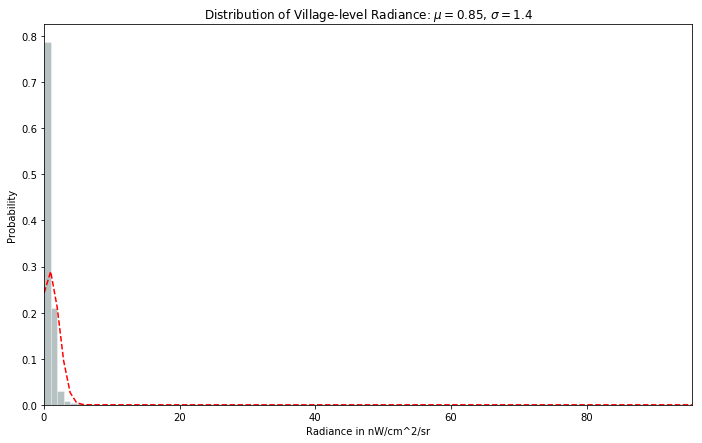

In [339]:
### a non-transfored histogram to show how wonky the data is

x = df3['Lights at Night']
num_bins = 100
plt.figure(figsize=(12,7))
n, bins, patches = plt.hist(x, num_bins, normed=1, facecolor='darkslategrey', alpha=0.35, edgecolor=(1,1,1))

# mean and standard deviations
mu = np.mean(x)
sigma = np.std(x)

# add a 'best fit' line
print(np.max(x))
y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'r--')
plt.xlabel('Radiance in nW/cm^2/sr')
plt.ylabel('Probability')
plt.title('Distribution of Village-level Radiance: $\mu={:0.2}$, $\sigma={:0.2}$'.format(mu, sigma))

#plt.xlabel('Smarts')
#plt.ylabel('Probability')

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
pylab.xlim([x.min(),x.max()])
plt.show()

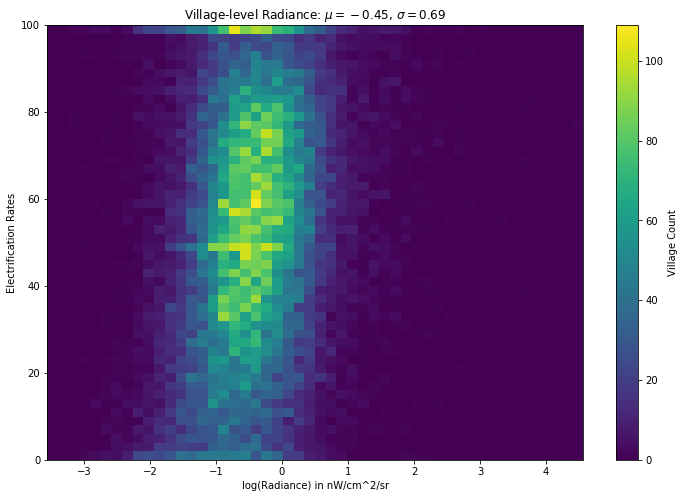

In [333]:
# a 2D histogram version of above data

from matplotlib.colors import LogNorm

x = np.log(df3['Lights at Night'])
y = df3['Percentage Electrified']

mu = np.mean(x)
sigma = np.std(x)

plt.figure(figsize=(12,8))
#plt.hist2d(x, y, bins=52, norm=LogNorm())
plt.hist2d(x, y, bins=(50, 50))
plt.colorbar().set_label('Village Count')
pylab.ylim([y.min(),y.max()])
#pylab.xlim([x.min(),x.max()])
plt.xlabel('log(Radiance) in nW/cm^2/sr')
plt.ylabel('Electrification Rates')
plt.title('Village-level Radiance: $\mu={:0.2}$, $\sigma={:0.2}$'.format(mu, sigma))
plt.show()

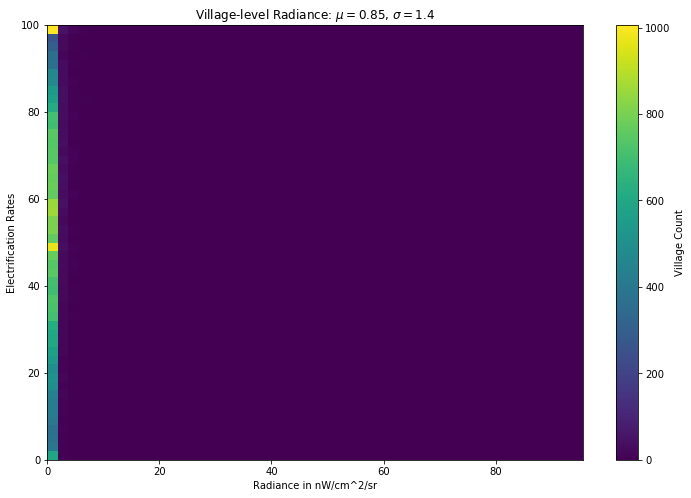

In [340]:
# a 2D histogram version of above data

from matplotlib.colors import LogNorm

x = df3['Lights at Night']
y = df3['Percentage Electrified']

mu = np.mean(x)
sigma = np.std(x)

plt.figure(figsize=(12,8))
#plt.hist2d(x, y, bins=52, norm=LogNorm())
plt.hist2d(x, y, bins=(50, 50))
plt.colorbar().set_label('Village Count')
pylab.ylim([y.min(),y.max()])
#pylab.xlim([x.min(),x.max()])
plt.xlabel('Radiance in nW/cm^2/sr')
plt.ylabel('Electrification Rates')
plt.title('Village-level Radiance: $\mu={:0.2}$, $\sigma={:0.2}$'.format(mu, sigma))
plt.show()

Coefficients: 
 [[ 7.66493514]]
Mean squared error: 654.75
R-squared: 0.05


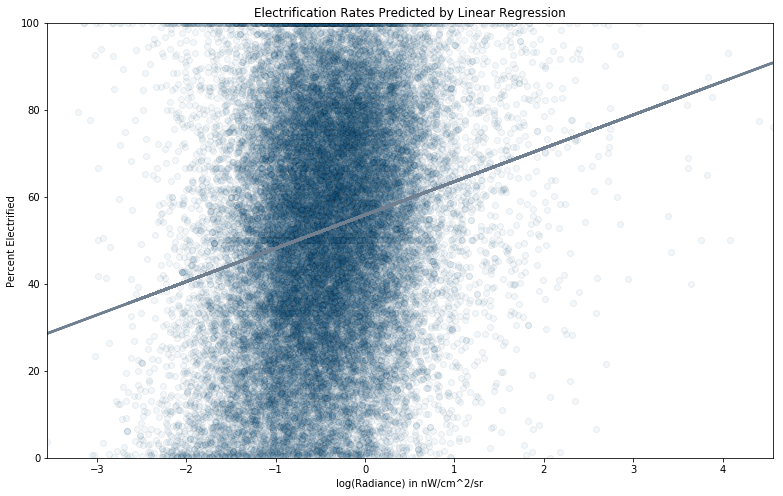

In [365]:
### basic linear regression model using radiance values regressed to electrification rates

regr = linear_model.LinearRegression()
# x = df3['Lights at Night'].values
# y = df3['Percentage Electrified'].values

x = df3.iloc[:, 2].values
y = df3.iloc[:, 3].values
x = np.log(x)

x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

# to set aside test data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=42)
regr.fit(X_train, y_train)

# run the model to predict y as a function of x
y_pred = regr.predict(X_test)

# evaluate model
# coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('R-squared: %.2f' % r2_score(y_test, y_pred))

# plot the model predictor
#fig, ax = plt.subplots()
plt.figure(figsize=(13,8))
plt.scatter(x, y, edgecolors=(0,0,0,), alpha = 0.06)
plt.plot(x, regr.predict(x), 'slategrey', lw=2.5)
plt.xlabel('log(Radiance) in nW/cm^2/sr')
plt.ylabel('Percent Electrified')
plt.title('Electrification Rates Predicted by Linear Regression')
pylab.ylim([y.min(),y.max()])
pylab.xlim([x.min(),x.max()])
plt.show()

# fig, ax = plt.subplots()
# ax.scatter(y, predicted, edgecolors=(0, 0, 0))
# ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
# ax.set_xlabel('Measured')
# ax.set_ylabel('Predicted')
# plt.show()

In [313]:
"""
The rest of this is from the multple regression analysis.
"""
villageDF = pd.read_csv('multiple_features.csv')
villageDF.head(3)

,Unnamed: 0,id,mean,max,10th,25th,50th,75th,90th,percentage
0,1,218888,0.324371,0.868426,0.205116,0.236085,0.312921,0.376298,0.437364,24.052288
1,4,217897,0.566512,0.897369,0.356537,0.441081,0.541048,0.667392,0.897369,23.054755
2,5,235232,0.643711,0.786491,0.600428,0.618670,0.632328,0.664203,0.687305,31.410256


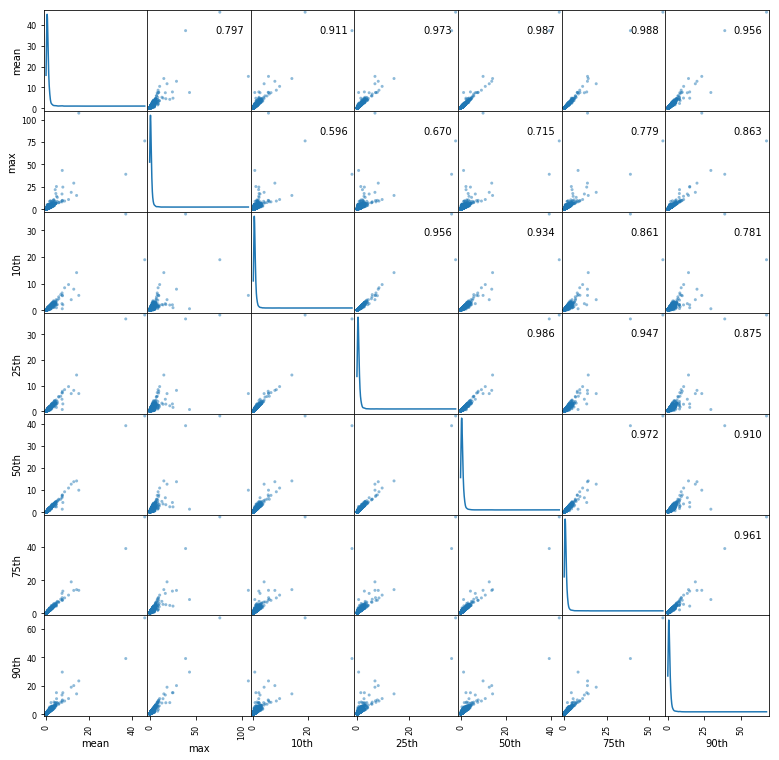

In [331]:
"""
Data exploration: Scatterplot Matrix to look at correlation between independent variables
"""
from pandas.plotting import scatter_matrix

independent_variables = villageDF[['mean', 'max', '10th', '25th', '50th', '75th', '90th']]
axes = scatter_matrix(independent_variables, alpha=0.5, figsize=(13, 13), diagonal='kde')
corr = independent_variables.corr().as_matrix()
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')
plt.show()
